# Question 1

Are contributors of comments (commit comments, issue comments, pull request comments) more likely to contribute to packages they depend on (or to packages that depend on them) than to other packages?

*** I think to answer this question we need all comments of users who have contributed on a package... to this end, we need to scrap github to find all comments of a user. ( am I right? or we just consider the downloaded comments of packages)

In this notebook we use comments(commit comments, issue comments, pull request comments) on selected packages extracted from github api

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API , DATE_RANGE
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:6]

In [2]:
all_comments = (
    read_comments()
    #[lambda x: x['author_assoc'] != 'NONE']
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at']))
)
all_comments.head()

,Name,user_login,author_assoc,created_at,type
0,itertools,Antti,NONE,2017-09-05 10:03:23,cmt
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt


In [3]:
df_pkgdpd_relation = (
    pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',
                    parse_dates=['fst_release','lst_release','first_time','last_time'])
    [['package','target']]
)
df_pkgdpd_relation.head()

,package,target
0,BrewStillery,gtk
1,BrewStillery,regex
2,BrewStillery,gio
3,BrewStillery,gdk
4,ConExpression,rand


#### Group comments by user and package

In [4]:
new_df = (
    all_comments
    [['Name','user_login','author_assoc']]
    .assign(count = 1)
    .groupby(['user_login','Name','author_assoc'])
    .sum()
    .reset_index()
)
new_df.shape

(11777, 4)

In [5]:
new_df.head()

,user_login,Name,author_assoc,count
0,007pig,mio,NONE,1
1,00imvj00,gotham,NONE,1
2,00shiv,image,NONE,3
3,0610919566,hyper,NONE,2
4,0X1A,cargo,NONE,2


#### Number of dependent packages a user commented on

In [6]:
#this function checks all packages a user commented on
def check_dep(row):
    
    #find package name of this row
    pkgs = new_df[lambda x: x['user_login'] == row['user_login']]
    
    #find other packages this user commented on
    parray = pkgs[pkgs.apply(lambda x: x['Name'] != row['Name'],axis=1)]

    relcount = 0
    
    #this package is dependecy of others or others is dependency of this package?
    for i in range(0,len(parray)):
        if ((parray.iloc[i]['Name'] in df_pkgdpd_relation[lambda x: x['package'] == row['Name']]['target'].values 
             and parray.iloc[i]['author_assoc'] != 'NONE' )
            or (row['Name'] in df_pkgdpd_relation[lambda x: x['package'] == parray.iloc[i]['Name']]['target'].values 
                and row['author_assoc'] != 'NONE')):
            relcount+=1
    return relcount

In [7]:
#test dataset
#df_test = new_df[lambda x: x['user_login'] == '0xbrt']
#df_test['rela_status'] = df_test.apply(lambda x: check_dep(x),axis=1)
#df_test

#to find how many dependent packages a user commented on...
new_df['rela_status'] = new_df.apply(lambda x: check_dep(x),axis=1)
new_df.head()

,user_login,Name,author_assoc,count,rela_status
0,007pig,mio,NONE,1,0
1,00imvj00,gotham,NONE,1,0
2,00shiv,image,NONE,3,0
3,0610919566,hyper,NONE,2,0
4,0X1A,cargo,NONE,2,0


(-5, 400)

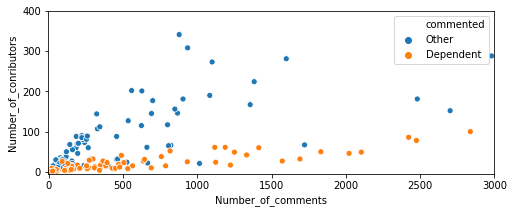

In [9]:
df_temp_box = (
    new_df
    .assign(commented = lambda x:  x['rela_status'] != 0 )
    .assign(rel_count=1)
    .groupby(['commented','Name'])
    .sum()
    .reset_index()
    .assign(commented = lambda x: ['Dependent' if y == True else 'Other' for y in x['commented']])
    .rename(columns={'count':'Number_of_comments','rel_count':'Number_of_conributors'})
)
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
ax = seaborn.scatterplot(df_temp_box['Number_of_comments'],df_temp_box['Number_of_conributors'],hue=df_temp_box['commented'])
plt.xlim(-5,3000)
plt.ylim(-5,400)


### Number of dependent packages developers commented on vs other packages

In this part I want to calculate number of dependent packages developers commented on. this is a sign of how developers comment on packages they depend on or they depending on them. I'm going to compare number of dependent pagackages developers commented on vs other packages.

In [10]:
df_tmp2 = (
    all_comments
    .drop_duplicates(subset=['Name','user_login','author_assoc'])
    .dropna()
)
df_tmp2['rela_status'] = df_tmp2.apply(lambda x: check_dep(x),axis=1)

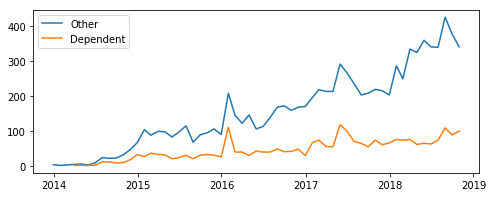

In [11]:
df_temp = (
    df_tmp2
    .assign(commented = lambda x:  x['rela_status'] != 0 )
    .assign(rel_count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'commented'])
    .sum()
    .reset_index()
    .assign(commented = lambda x: ['Dependent' if y == True else 'Other' for y in x['commented']])
)
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
for item in df_temp.commented.unique():
    ax.plot(df_temp[lambda x: x['commented'] == item]['created_at'],df_temp[lambda x: x['commented'] == item]['rel_count'])
    
ax.legend(df_temp.commented.unique())

According to this plot, the answer to this question is NO. although developers are generally going to comment on dependent packages they are more likely to comment on packages they have no dependency on them. I think we can change the result of this part by downloading all comments of developers, not just the part of selected packages.

### Number of comments on dependent packages regarding the type of comments

In this part, I want to investigate which types of comments developers are more likely to contribute 

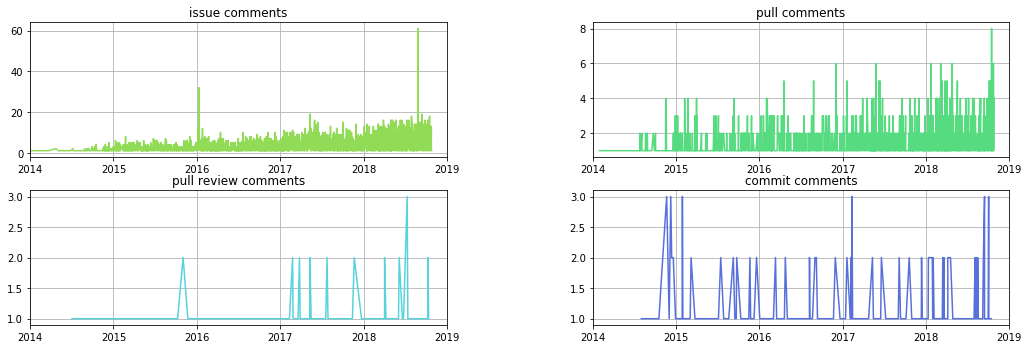

In [12]:
df_plot = (
    df_tmp2
    .assign(commented = lambda x:  x['rela_status'] != 0 )
    .assign(rel_count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1D'),'type','commented'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (16,5)

dic = {'isu':'issue comments','cmt':'commit comments','pul':'pull comments','prq':'pull review comments'}

plt.figure(1)
i = 221
for item in df_plot.type.unique():
    plt.subplot(i)
    plt.plot(df_plot[lambda x: x['type'] == item]['created_at'],df_plot[lambda x: x['type'] == item]['rel_count'],color=palet[i-219])
    plt.xlim(DATE_RANGE)
    plt.title(dic[item])
    plt.grid(True)
    i+=1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
#plt.legend(df_plot.type.unique())

this plot demonstrates that developers are more likely to comment on packages they are depending on or they depend on them with issue or pull comments

### how many contributors (= that made a comment) went to contribute in a dependent packages.

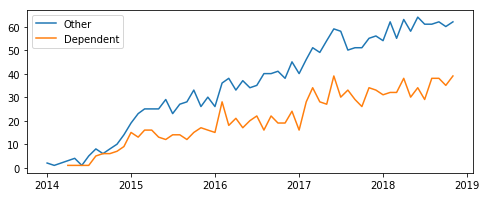

In [13]:
df_numcntr = (
    df_tmp2
    .assign(commented = lambda x:  x['rela_status'] != 0 )
    .assign(cntr_count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'commented','Name'])
    .sum()
    .reset_index()
    [['created_at','commented','Name','cntr_count']]
    .assign(cntr_count = lambda x: [1 if y >1 else y for y in x['cntr_count']] )
    .groupby([pandas.Grouper(key='created_at',freq='1D'),'commented'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (8,3)
fig, ax = plt.subplots()
for item in df_numcntr.commented.unique():
    ax.plot(df_numcntr[lambda x: x['commented'] == item]['created_at'],df_numcntr[lambda x: x['commented'] == item]['cntr_count'])
    
ax.legend(df_temp.commented.unique())

As the plot shows the number of contributors of comments on dependent packages is less than other packages and both of them are increasing over time.